# Compare model with UDB and SERPENT data

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import svm
import pickle

In [2]:
model_dict = pickle.load(open('lin_dep.pkl', 'rb'))

In [81]:
data_dict = pickle.load(open('all_data.pkl', 'rb'))

In [82]:
udb_df = data_dict['UDB']
# filter out 0 bu values
serpent_df = data_dict['SERPENT'][data_dict['SERPENT'].bu != 0]

data_dict = {'UDB': udb_df,
             'SERPENT': serpent_df}

In [83]:
iso_list = list(udb_df)[5:]

In [84]:
data_info = {'Type': ['SERPENT', 'UDB'],
             'number of isotopes': [len(list(serpent_df)[:-2]),
                                    len(list(udb_df)[5:])],
             'number of calculations': [serpent_df.shape[0], udb_df.shape[0]]}

info_df = pd.DataFrame.from_dict(data_info)
info_df = info_df.set_index('Type')
info_df

,number of isotopes,number of calculations
Type,,
SERPENT,1114,200
UDB,60,104551


In [122]:
# difference between UDB and SERPENT
serpent_row = serpent_df.iloc[0]
serpent_bu = serpent_df.iloc[0]['bu']
serpent_enr = serpent_df.iloc[0]['init_enr']
enr_bu = [serpent_enr, serpent_bu]
print('Example SERPENT enrichment and burnup: ', enr_bu)
# UDB datapoint closest to serpent enr_bu
udb_df['err'] = abs(udb_df['bu'] - serpent_bu) + abs(udb_df['init_enr'] - serpent_enr) * 10000
minimum_err = udb_df['err'].idxmin()
udb_df = udb_df.drop(columns='err')
average_assem = udb_df.loc[minimum_err]
print('UDB assembly closest: ', [average_assem['init_enr'], average_assem['bu']])


print('Isotope', '\t', 'SERPENT', '\t', 'UDB', '\t\t\t', '%Error')
for iso in iso_list:
    err = (serpent_row[iso] - average_assem[iso]) / serpent_row[iso] * 100
    print(iso, '\t', serpent_row[iso], '\t', average_assem[iso], '\t', err)

Example SERPENT enrichment and burnup:  [3.2999999999999998, 43809.199999999997]
UDB assembly closest:  [3.2999999999999998, 43872.0]
Isotope 	 SERPENT 	 UDB 			 %Error
zr-95 	 6.19158883927e-05 	 1.19880081345e-06 	 98.0638236088
zr-93 	 0.000917666258151 	 0.0010461326258 	 -13.9992471673
ra-226 	 3.67762604441e-15 	 5.7414438267e-14 	 -1461.18206619
ru-103 	 4.8617034867e-05 	 7.3565459723e-08 	 99.8486837794
ru-106 	 0.000231054800791 	 0.000103266591019 	 55.3064508221
sb-124 	 5.43148845867e-08 	 1.09009293108e-09 	 97.9930125243
sb-125 	 1.31961856559e-05 	 1.15856654631e-05 	 12.2044372124
pu-238 	 0.000247886470912 	 0.000324962713664 	 -31.0933640182
pu-239 	 0.00455677123098 	 0.00658177198549 	 -44.439377179
np-237 	 0.000587514171993 	 0.000636809768566 	 -8.39053744124
nb-95 	 3.4597010099e-05 	 1.41387465653e-06 	 95.913303917
pa-231 	 7.06032615193e-11 	 5.95248520019e-10 	 -743.089266998
pd-107 	 0.000349796812502 	 0.000354110950064 	 -1.23332672202
pm-147 	 0.0001906

/home/teddy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


## bu and enrichment distribution

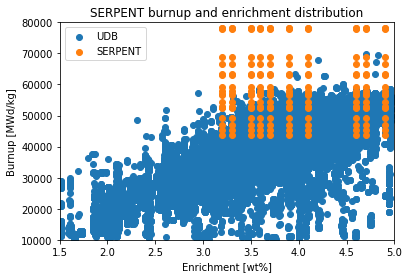

In [88]:
for key, val in data_dict.items():    
    plt.scatter(val['init_enr'], val['bu'], label=key)
plt.xlabel('Enrichment [wt%]')
plt.ylabel('Burnup [MWd/kg]')
plt.xlim(1.5, 5.0)
plt.ylim(1e4, 8e4)
plt.title('%s burnup and enrichment distribution' %key)
plt.legend()
plt.show()
plt.close()

In [91]:

def get_a(f):
    z = ''
    for i in f:
        if i.isdigit():
            z += i
    return int(z)

def deplete_using_rom(dep_dict, enr_bu):
    depleted_composition_rom = {}
    for indx, enr_bu_set in enumerate(enr_bu):
        depleted_composition_rom[indx] = {}
        x = [enr_bu_set]
        for iso, alg in dep_dict.items():
            if 'alg' in iso:
                continue
            else:
                if any(i.isdigit() for i in dep_dict[iso + '_alg']):
                    deg = get_a(dep_dict[iso + '_alg'])
                    poly = sklearn.preprocessing.PolynomialFeatures(degree=deg)
                    depleted_composition_rom[indx][iso] = dep_dict[iso].predict(poly.fit_transform(x))[0]
                else:
                    depleted_composition_rom[indx][iso] = dep_dict[iso].predict(x)[0]

    print('\n')
    return depleted_composition_rom

In [92]:
serpent_df

,h-1,h-2,h-3,he-3,he-4,li-6,li-7,be-9,b-10,b-11,...,cm-239,cm-251,bk-249,bk-250,bk-251,cf-249,cf-250,cf-251,bu,init_enr
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.395068e-24,5.410369e-22,1.892486e-11,2.793771e-25,1.789785e-21,4.551594e-12,1.607664e-22,3.622407e-18,43809.2,3.3
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.155961e-24,1.172249e-21,2.889141e-11,4.662480e-25,3.877053e-21,6.566934e-12,2.369079e-22,5.849315e-18,45376.8,3.3
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.365433e-24,1.894497e-21,4.301780e-11,7.350423e-25,6.266203e-21,9.619383e-12,3.607499e-22,9.559702e-18,46954.1,3.3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.952803e-24,3.472093e-21,7.340588e-11,1.332676e-24,1.148486e-20,1.672360e-11,6.669447e-22,1.883324e-17,49242.1,3.3
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.728692e-24,7.368301e-21,1.436728e-10,2.764206e-24,2.437389e-20,3.439038e-11,1.475030e-21,4.389078e-17,52327.6,3.3
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.831251e-24,8.440558e-21,1.611658e-10,3.124712e-24,2.792098e-20,3.898041e-11,1.690486e-21,5.066445e-17,52881.9,3.3
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.799709e-24,8.459809e-21,1.612124e-10,3.125666e-24,2.794822e-20,3.899255e-11,1.691061e-21,5.068245e-17,52883.3,3.3
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.725713e-24,8.495890e-21,1.621654e-10,3.145497e-24,2.810387e-20,3.924578e-11,1.703001e-21,5.105767e-17,52912.1,3.3
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.940813e-24,1.170465e-20,2.183478e-10,4.318494e-24,3.871937e-20,5.446967e-11,2.428007e-21,7.393881e-17,54392.8,3.3
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.399807e-24,1.808423e-20,3.283651e-10,6.635332e-24,5.982485e-20,8.562396e-11,3.941772e-21,1.220188e-16,56512.8,3.3


In [95]:
enr_bu = [[serpent_df.iloc[0]['init_enr'], serpent_df.iloc[0]['bu']]]
dep_dict = deplete_using_rom(model_dict, enr_bu)[0]

In [101]:
for key, val in dep_dict.items():
    # err = (serpent_df.iloc[0][key] - val) / serpent_df.iloc[0][key]
    err = (serpent_df.iloc[0][key] - val)
    if key in ['pu-239', 'u-235', 'cs-137']:
        print('\n\n')
    print(key, '\t', val, '\t', serpent_df.iloc[0][key], '\t', err)

zr-95 	 1.23913929586e-06 	 6.19158883927e-05 	 6.06767490969e-05
zr-93 	 0.0010346159826 	 0.000917666258151 	 -0.000116949724452
ra-226 	 8.02817565029e-14 	 3.67762604441e-15 	 -7.66041304585e-14
ru-103 	 7.60614593242e-08 	 4.8617034867e-05 	 4.85409734076e-05
ru-106 	 0.000101464251367 	 0.000231054800791 	 0.000129590549424
sb-124 	 1.17161286784e-09 	 5.43148845867e-08 	 5.31432717188e-08
sb-125 	 1.12766275758e-05 	 1.31961856559e-05 	 1.91955808016e-06
pu-238 	 0.000360627850157 	 0.000247886470912 	 -0.000112741379245



pu-239 	 0.00675798023241 	 0.00455677123098 	 -0.00220120900143
np-237 	 0.000661738411208 	 0.000587514171993 	 -7.42242392155e-05
nb-95 	 1.46286961018e-06 	 3.4597010099e-05 	 3.31341404888e-05
pa-231 	 6.81808229625e-10 	 7.06032615193e-11 	 -6.11204968106e-10
pd-107 	 0.000358740023162 	 0.000349796812502 	 -8.94321065939e-06
pm-147 	 0.000145812278397 	 0.000190687661055 	 4.4875382658e-05
pu-240 	 0.00305578068185 	 0.00166001790362 	 -0.0013957627782